# Prediction Analysis

## Import Models and Data

In [136]:
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
np.set_printoptions(suppress=True)

In [137]:
dt_model = joblib.load('../models/best_decision_tree_model.joblib')
knn_model = joblib.load('../models/best_knn_model.joblib')
best_rf_model = joblib.load('../models/best_random_forest_model.joblib')
best_adaboost_model = joblib.load('../models/best_adaboost_model.joblib')

In [138]:
data = pd.read_csv("../data/fetal_health_mod.csv")
x_train = np.load('../data/x_train.npy')
x_test = np.load('../data/x_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

## Approach

- take the best/most interesting model
- do the following on training data and then testing data
- see the distribution of predicted classes (how many were predicted 1, 2, and 3?)
- see only where the predictions were incorrect
- see any patterns in wrong predictions (ex: when actual answer was 1, it always predicted 2)
- then create custom error rates 
- continue creating custom metrics to give insights into model weaknesses

In [139]:
model = best_rf_model
y_pred = model.predict(x_test)
print(y_pred[:20])
print(y_test[:20])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [140]:
print(f"Prediction Distribution:\n{pd.Series(y_pred).value_counts()}")
print(f"\nActual Distribution:\n{pd.Series(y_test).value_counts()}")

Prediction Distribution:
1.0    338
2.0     55
3.0     33
Name: count, dtype: int64

Actual Distribution:
1.0    334
2.0     57
3.0     35
Name: count, dtype: int64


### Observation
Some instances which are 2.0 or 3.0 category are being classified as 1.0. In other words, fetuses which are suspect and pathological level (unhealthy) are being classified as healthy. These are examples of false negatives, which are very dangerous, especially in this case.

The effect of false negatives, as discussed in `modeling.ipynb`, is the endangerment of the fetus by not realizing an unhealthy fetus needs medical intervention.

Let's see where the classification is going wrong.

In [141]:
assert len(y_pred) == len(y_test)
assert len(x_test) == len(y_test)
error_count = 0
type_of_error = {}
true_value_errors = {}
index = 0
error_indices = []
for pred, true in zip(y_pred, y_test):
    if pred != true:
        error_indices.append(index)
        key = f"Prediction: {pred} | True: {true}"
        # print(key)
        if key not in type_of_error.keys():
            type_of_error[key] = 1
        else:
            type_of_error[key] += 1
        
        if true not in true_value_errors.keys():
            true_value_errors[true] = 1
        else:
            true_value_errors[true] += 1
        error_count+=1
    index+=1

assert index == len(y_pred) == len(y_test)
assert len(error_indices) == error_count
error_rate = error_count / len(y_pred)
print(f"Error Rate: {error_count}/{len(y_pred)} = {error_rate*100:.2}%")
print(type_of_error)
key_with_max_value = max(type_of_error, key=type_of_error.get)
print(f"Most prevalent misclassifiction: {key_with_max_value}")

Error Rate: 24/426 = 5.6%
{'Prediction: 2.0 | True: 1.0': 8, 'Prediction: 1.0 | True: 2.0': 12, 'Prediction: 2.0 | True: 3.0': 2, 'Prediction: 3.0 | True: 1.0': 1, 'Prediction: 1.0 | True: 3.0': 1}
Most prevalent misclassifiction: Prediction: 1.0 | True: 2.0


### Observation
The types of misclassifications are:

Type 1: Predicting 1 when truly 2 => 12 occurences

Type 2: Predicting 2 when truly 1 => 8 occurences

Type 3: Predicting 2 when truly 3 => 2 occurences

Type 4: Predicting 3 when truly 1 => 1 occurence

Type 5: Predicting 1 when truly 3 => 1 occurence
<br><br>

This can be translated to:

Type 1: Predicting HEALTHY when SUSPECT => 12 occurences (***)

Type 2: Predicting SUSPECT when HEALTHY => 8 occurences

Type 3: Predicting SUSPECT when PATHOLOGICAL => 2 occurences

Type 4: Predicting PATHOLOGICAL when HEALTHY => 1 occurence

Type 5: Predicting HEALTHY when PATHOLOGICAL => 1 occurence (***)

_(***) indicates dangerous misclassifications_
<br><br>


Even with GridSearch optimizing for recall, there are many false negatives.

{1.0: 9, 2.0: 12, 3.0: 3}


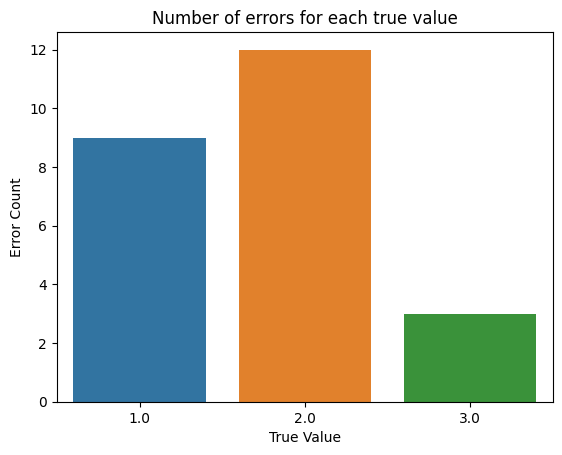

In [142]:
# graph errors where the true value was 1,2,or 3
print(true_value_errors)
sns.barplot(x=list(true_value_errors.keys()), y=list(true_value_errors.values()))
plt.title('Number of errors for each true value')
plt.xlabel('True Value')
plt.ylabel('Error Count')
plt.show()

In [158]:
# do again
# count number of 2 errors
# divide by number of 2 true values. 
# do for other labels.
for label in true_value_errors.keys():
    true_2_errors = true_value_errors[label]
    # print(true_2_errors)
    total_2_errors = np.count_nonzero(y_test == label)
    # print(total_2_errors)
    percentage_2_error = true_2_errors/total_2_errors*100
    print(f"{label} error rate: {true_2_errors}/{total_2_errors} = {percentage_2_error:.3}%")

1.0 error rate: 9/334 = 2.69%
2.0 error rate: 12/57 = 21.1%
3.0 error rate: 3/35 = 8.57%


### Observation

2.0's are getting misclassified more than other labels. This is surprising considering 3.0's are the rarest to be found in the dataset, training and testing. So I would expect 3.0's to be misclassified more.

The most challenging part is to find out why they're being misclassified...

In [143]:
# modify previous code to keep track of pred and true value for each index in y_pred and y_true. 
# pull those cases from x_test and see for any patterns in misclassification type 1.
col_names = data.columns[:-1].tolist()
# print(col_names)

# find out the average value for each column in x_train. This will show what kind of numbers the model is looking for in each label.
# average of each column in x_train
column_wise_mean = data.groupby('fetal_health').mean()
# print(column_wise_mean)

# EX: To get mean value for 'baseline value' feature with label '2.0'
# print(column_wise_mean['baseline value'][2.0])

str_out = f"Misclassification Expansion:\n\nFeature names: {col_names}\n\n"
for index in error_indices:
    predicted_value = y_pred[index]
    true_value = y_test[index]
    row_values = x_test[index]
    assert len(row_values) == len(col_names)
    true_diff = []
    pred_diff = []
    for col_name,value in zip(col_names, row_values):
        # print(col_name)
        true_mean_value = column_wise_mean[col_name][true_value]
        true_perc_diff = abs(round((value - true_mean_value)/true_mean_value*100, 2))
        # print(value,true_mean_value, true_perc_diff)
        true_diff.append(true_perc_diff)

        pred_mean_value = column_wise_mean[col_name][predicted_value]
        pred_perc_diff = abs(round((value - pred_mean_value)/true_mean_value*100, 2))
        pred_diff.append(pred_perc_diff)

    str_out += f"Pred: {predicted_value} | True: {true_value}\n% Difference from true feature means: {true_diff} Avg: {np.mean(true_diff):.2}\n% Difference from pred feature means: {pred_diff}  Avg: {np.mean(pred_diff):.2}\n\n"

with open("../log.txt", "w") as file:
    file.write(str_out)

### Approach

I wanted to see for each incorrect prediction, how much did its feature values differ from the average given its label? For example, if a fetus was predicted healthy, but was in reality suspect or pathological,
- What were its feature values?
- What is the average value for the features of a healthy fetus?
- What is the difference between these values with respect to a given feature?

The output of this can be found in `log.txt`

### Insights
- Difference between value and mean value are very high for few features, namely `accelerations`, `percentage_of_time_with_abnormal_long_term_variability`, and `histogram_variance`.
- Percent difference for `accelerations` is noticeably 100% in a lot of cases. This is for a simple reason. The value for the given instance is 0 and the average value for that feature + label is a very small number. So, when calculating percent difference, it becomes _(0 - 0.001) / 0.001 * 100 = 100%_ 

Further analysis pending...